In [64]:
import os
import sys
while not os.getcwd().endswith('ml'):
    os.chdir('..')
sys.path.insert(0, os.getcwd())

In [65]:
import math
import copy
import cv2
import pandas as pd
import numpy as np
import random
from shutil import copyfile
from pathlib import Path
from matplotlib import pyplot as plt

from kaggle_problems.rosneft_proppant.helpers import *

import tensorflow as tf
from tensorflow.keras import Model
from  tensorflow.keras.preprocessing.image import ImageDataGenerator

from ml_helpers.image_helpers import display_images

from kaggle_problems.rosneft_proppant.common import *
from kaggle_problems.rosneft_proppant.RPCC_metric_utils_for_participants import fraction_sievs
from sklearn.model_selection import train_test_split
import pickle


In [66]:
train = pd.read_csv("{}/RPCC_labels.csv".format(DATA_DIR))
train.describe()

,ImageId,6,7,8,10,12,14,16,18,20,...,35,40,45,50,60,70,80,100,pan,prop_count
count,790.000000,756.0,756.0,756.0,756.0,756.0,756.0,756.000000,756.000000,756.000000,...,756.000000,756.000000,756.000000,756.000000,756.0,756.0,756.0,756.0,756.0,64.000000
mean,395.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.011115,0.325205,0.376608,...,0.009513,0.033514,0.000036,0.000072,0.0,0.0,0.0,0.0,0.0,1868.812500
std,228.197648,0.0,0.0,0.0,0.0,0.0,0.0,0.008205,0.235431,0.233366,...,0.030045,0.073941,0.000495,0.000363,0.0,0.0,0.0,0.0,0.0,718.401883
min,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.006100,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,688.000000
25%,198.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.005146,0.008131,0.090836,...,0.000000,0.000300,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1204.750000
50%,395.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.010000,0.370200,0.435100,...,0.000000,0.000600,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1955.500000
75%,592.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.015650,0.486200,0.563200,...,0.000000,0.005600,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,2487.000000
max,790.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.041200,0.844800,0.825500,...,0.187500,0.270995,0.007800,0.005100,0.0,0.0,0.0,0.0,0.0,3029.000000


In [68]:
fractions = train.fraction.unique()
fractions = fractions[:-1] # delete nana
print(fractions)

['20/40' '20/40_pdcpd_bash_lab' '16/20']


In [69]:
for i in bins:
    train = train[~train[i].isnull()]

train["filename"] = train['ImageId'].astype(str) + '.jpg'

In [70]:
train['y'] = train.apply(lambda x: np.array([x[i] for i in bins]), axis=1)

### Model

In [47]:
class BinsExtraction(Model):
    def __init__(self, fraction):
        super(BinsExtraction, self).__init__()
        self.FilterSize1 = 32
        self.FilterSize2 = 16
        self.FilterSize3 = 8
        
        self.model_layers = [
            tf.keras.layers.Conv2D(filters=self.FilterSize1, kernel_size=(5, 5), strides=(5, 5)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
            tf.keras.layers.Dropout(rate=0.3),

            tf.keras.layers.Conv2D(filters=self.FilterSize2, kernel_size=(3, 3), strides=(3, 3)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
            tf.keras.layers.Dropout(rate=0.3),
            
            tf.keras.layers.Conv2D(filters=self.FilterSize3, kernel_size=(3, 3), strides=(3, 3)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
            tf.keras.layers.Dropout(rate=0.3),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(10, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(rate=0.5),
            tf.keras.layers.Dense(len(fraction_sievs[fraction]['all']), activation='softmax'),
        ]

    def call(self, x, *args, **kwargs):
        for model_layer in self.model_layers:
            x = model_layer(x, *args, **kwargs)
        return x

#### Train Input Generator

In [48]:
def get_train_val_datagen(train, fraction):
    train_fraction = train[train['fraction'] == fraction]
    
    train_fraction, val_fraction = train_test_split(train_fraction, train_size=0.8)
    
    bins_fraction = fraction_sievs[fraction]['all']
    
    datagen = ImageDataGenerator()

    train_generator = datagen.flow_from_dataframe(
            train_fraction.sample(n=int(len(train_fraction) * DF_RATE)),
            directory=TRAIN_DIR,
            x_col='filename', 
            y_col=bins_fraction,
            target_size=TARGET_SHAPE,
            batch_size=16,
            class_mode='other')
    
    val_generator = datagen.flow_from_dataframe(
        val_fraction.sample(n=int(len(val_fraction) * DF_RATE)),
        directory=TRAIN_DIR,
        x_col='filename', 
        y_col=bins_fraction,
        target_size=TARGET_SHAPE,
        batch_size=16,
        class_mode='other')
    return train_generator, val_generator

#### Input generator checking

/Users/skrrydg/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Found 70 validated image filenames.
Found 18 validated image filenames.


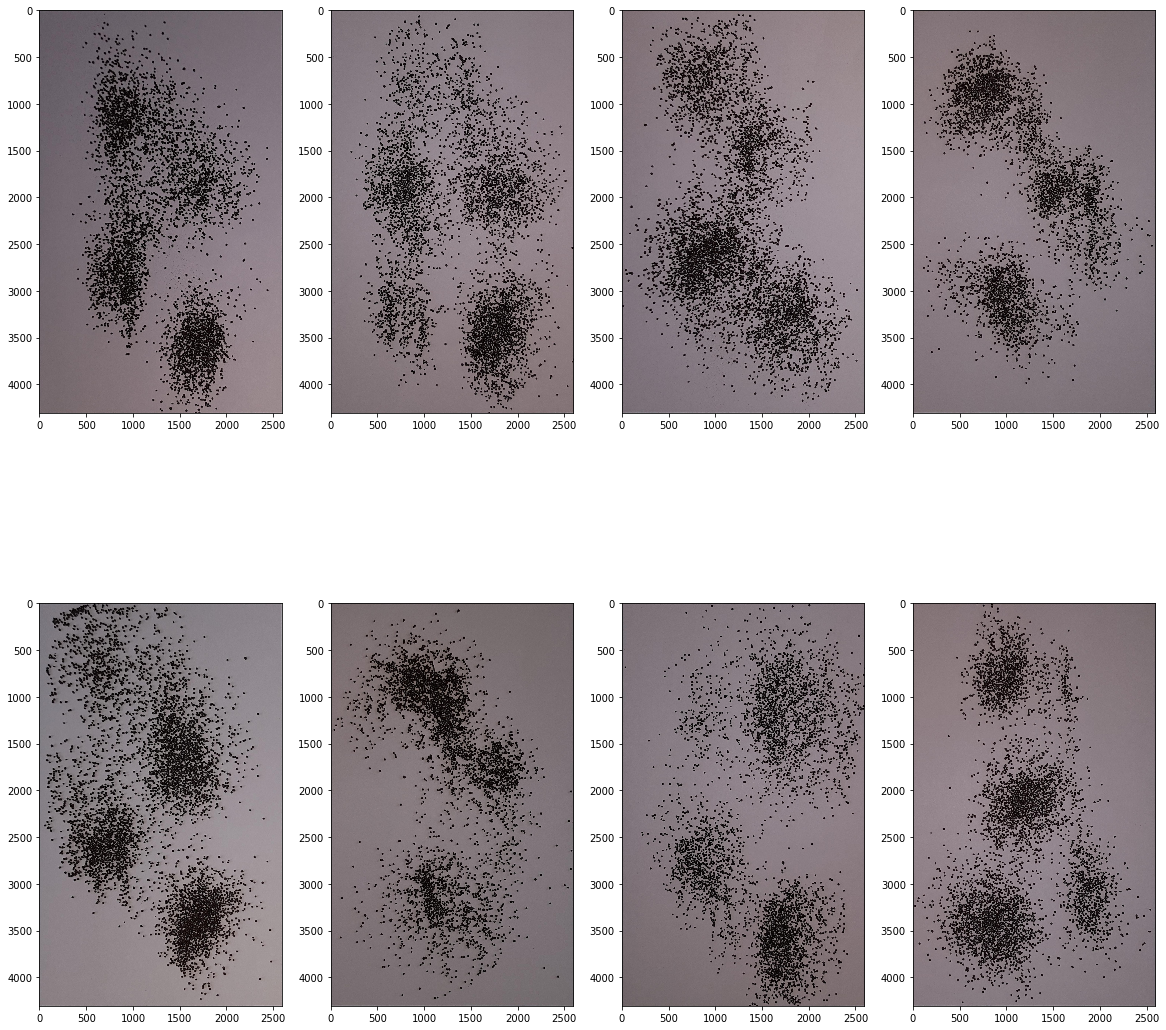

In [49]:
img, labels = get_train_val_datagen(train, '20/40')[0].next()
display_images(img[0:8].astype(int), 4)

In [50]:
print(labels)

[[0.000e+00 5.450e-02 5.662e-01 2.925e-01 7.980e-02 7.000e-03 2.000e-04]
 [0.000e+00 4.150e-02 4.189e-01 4.549e-01 6.750e-02 1.660e-02 7.000e-04]
 [0.000e+00 5.450e-02 5.662e-01 2.925e-01 7.980e-02 7.000e-03 2.000e-04]
 [0.000e+00 4.730e-02 4.144e-01 4.531e-01 7.180e-02 1.350e-02 2.000e-04]
 [0.000e+00 6.100e-03 6.225e-01 2.401e-01 1.223e-01 8.800e-03 3.000e-04]
 [0.000e+00 6.100e-03 6.225e-01 2.401e-01 1.223e-01 8.800e-03 3.000e-04]
 [0.000e+00 4.570e-02 5.227e-01 3.267e-01 9.470e-02 1.000e-02 4.000e-04]
 [0.000e+00 2.510e-02 6.226e-01 2.135e-01 0.000e+00 1.308e-01 4.000e-04]
 [0.000e+00 4.150e-02 4.189e-01 4.549e-01 6.750e-02 1.660e-02 7.000e-04]
 [0.000e+00 2.400e-02 5.404e-01 3.853e-01 3.650e-02 1.320e-02 8.000e-04]
 [0.000e+00 5.250e-02 5.359e-01 2.181e-01 1.875e-01 5.300e-03 0.000e+00]
 [0.000e+00 3.810e-02 6.140e-01 3.045e-01 3.760e-02 5.600e-03 4.000e-04]
 [0.000e+00 2.400e-02 5.404e-01 3.853e-01 3.650e-02 1.320e-02 8.000e-04]
 [0.000e+00 2.270e-02 5.825e-01 3.477e-01 3.410e-02

#### Callbacks

In [51]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [52]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

earlystop = EarlyStopping(patience=10)

callbacks = [earlystop, learning_rate_reduction]

In [75]:
def metric(true, predicted):
    return tf.keras.backend.mean(tf.math.reduce_sum((true - predicted) ** 2 / (true + predicted), axis=1))

In [76]:
for fraction, i in zip(fractions, range(len(fractions))):
    print(fraction)
    model = BinsExtraction(fraction)
    model.compile(
        loss=metric,
        optimizer='rmsprop',
        metrics=['mse']
    )

    train_datagen, val_datagen = get_train_val_datagen(train, fraction)

    history = model.fit(
        x=train_datagen,
        epochs=30,
        validation_data=val_datagen,
        callbacks=callbacks
    )
    
    with open(MODEL_DIR + "/history_model_benchmark_{}.pickle".format(i), 'wb') as f:
        pickle.dump(history.history, f)
        
    model.save(MODEL_DIR + "/model_benchmark_{}".format(fraction))

20/40
Found 70 validated image filenames.
Found 18 validated image filenames.


/Users/skrrydg/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


  ...
    to  
  ['...']
Train for 5 steps, validate for 2 steps
4/5 [=======================>......] - ETA: 22s - loss: 1.0559 - mse: 0.0696

KeyboardInterrupt: 

In [14]:
# model.save(MODEL_DIR + "/cnn_benchmark")

In [15]:
#model = tf.keras.models.load_model(MODEL_DIR + "/cnn_benchmark")

In [16]:
#model.summary()

Model: "bins_extraction"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  2432      
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  18496     
_________________________________________________________________
batch_normalization_1 (Batch multiple                  256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple              

In [ ]:
#predicted_labels = model.predict(img)

In [ ]:
# def get_bins_metric(predicted, true):
#     print(predicted.shape)
#     return 0.5 * np.sum((predicted - true) ** 2 / (predicted + true)) / predicted.shape[0]
    

In [ ]:
# print(get_bins_metric(predicted_labels, labels))

In [77]:
!jupyter nbconvert --to script kaggle_problems/rosneft_proppant/cnn_try.ipynb

[NbConvertApp] Converting notebook kaggle_problems/rosneft_proppant/cnn_try.ipynb to script
[NbConvertApp] Writing 5776 bytes to kaggle_problems/rosneft_proppant/cnn_try.py
